### 环境初始化

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

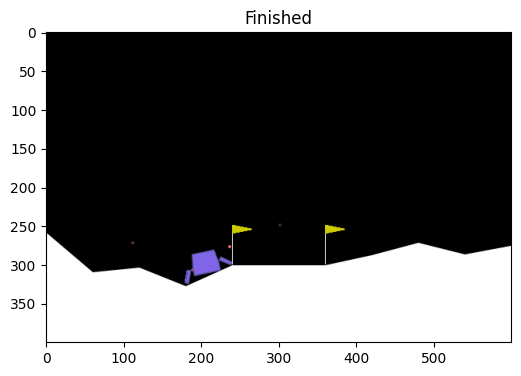

In [2]:
# 导入gym库
import gym

# 创建环境，指定渲染模式为rgb_array，如果是在IDE中可以改为'human'
env = gym.make('LunarLander-v2', render_mode='rgb_array')
# 重置环境
env.reset()
# 创建GymHelper
gym_helper = GymHelper(env, figsize = (6, 6))

# 循环N次
for i in range(100):
    gym_helper.render(title = str(i)) # 渲染环境
    action = env.action_space.sample() # 从动作空间中随机选取一个动作
    observation, reward, terminated, truncated, info = env.step(action) # 执行动作
    if terminated or truncated: # 如果游戏结束，则结束循环
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

### SAC

In [3]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import sys
import time
import random
import collections
from tqdm import * # 用于显示进度条

# 策略模型，给定状态生成各个动作的概率
class PolicyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyModel, self).__init__()
        
        # 使用全连接层构建一个简单的神经网络，ReLU作为激活函数
        # 最后加一个Softmax层，使得输出可以看作是概率分布
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim = 1)
        )

    # 定义前向传播，输出动作概率分布
    def forward(self, x):
        action_prob = self.fc(x)
        return action_prob

# Q网络模型，给定状态和动作样本对估计Q值
class QValueModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QValueModel, self).__init__()
        
        # 网络结构和策略模型类似，输出维度为动作空间的维度
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    # 定义前向传播，输出Q值估计
    def forward(self, x):
        value = self.fc(x)
        return value

In [4]:
# 经验回放缓冲区
class ReplayBuffer:
    # 构造函数，max_size是缓冲区的最大容量
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = collections.deque(maxlen = self.max_size)  # 用collections的队列存储，先进先出

    # 添加experience（五元组）到缓冲区
    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    # 从buffer中随机采样，数量为batch_size
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done
    
    # 返回缓冲区数据数量
    def __len__(self):
        return len(self.buffer)

In [8]:
# SAC算法
class SAC:
    # 构造函数，参数包含环境，学习率，折扣因子，更新目标网络参数，缓冲区大小
    def __init__(self, env, learning_rate=0.001, gamma=0.99, rho=0.01, buffer_size=10000):
        self.env = env
        self.gamma = gamma
        self.rho = rho
        self.replay_buffer = ReplayBuffer(max_size=buffer_size)
        
        # 设置一个较大的目标熵值，取负值转为最小化问题
        self.target_entropy = -np.log2(env.action_space.n)
        
        # 判断可用的设备是 CPU 还是 GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 创建模型，并将模型移动到指定设备上
        # 包括策略网络、两个Q值网络和它们对应的目标网络
        self.actor = PolicyModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.q1 = QValueModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.q2 = QValueModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_q1 = QValueModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_q2 = QValueModel(env.observation_space.shape[0], env.action_space.n).to(self.device)
        
        # 将Q值网络的参数复制到对应的目标网络中，以确保初始的Q值网络和目标网络参数相同
        for param, target_param in zip(self.q1.parameters(), self.target_q1.parameters()):
            target_param.data.copy_(param)
        for param, target_param in zip(self.q2.parameters(), self.target_q2.parameters()):
            target_param.data.copy_(param)
        
        # 定义Adam优化器
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.optimizer_q1 = torch.optim.Adam(self.q1.parameters(), lr=learning_rate)
        self.optimizer_q2 = torch.optim.Adam(self.q2.parameters(), lr=learning_rate)
        
        # alpha作为可学习参数，学习其对数值可确保alpha=exp(log_alpha)>0
        self.log_alpha = torch.tensor([0.0], device=self.device, requires_grad=True)
        self.optimizer_log_alpha = torch.optim.Adam([self.log_alpha], lr=learning_rate)

    # 使用模型生成动作概率分布并采样
    def choose_action(self, state):
        # 将状态转换为tensor输入模型
        state = torch.FloatTensor(np.array([state])).to(self.device)
        with torch.no_grad():
            action_prob = self.actor(state)
        
        # 生成分布后采样返回动作
        c = torch.distributions.Categorical(action_prob)
        action = c.sample()
        return action.item()
    
    # 模型更新
    def update(self, batch_size):
        # 从经验回放缓冲区中随机采样，并将其转换为numpy数组
        # 然后进一步转换为tensor，并将数据转移到指定计算资源设备上
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        # actions = torch.tensor(np.array(actions)).view(-1, 1).to(self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.long).view(-1, 1).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).view(-1, 1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).view(-1, 1).to(self.device)
        
        ##### Q网络更新 #####
        # 计算下一个状态的动作概率和对数
        next_action_prob = self.actor(next_states)
        log_next_prob = torch.log(next_action_prob + 1e-9) # 避免对零取对数
        
        # 计算目标Q值
        target_q1 = self.target_q1(next_states)
        target_q2 = self.target_q2(next_states)
        target_q_min = torch.min(target_q1, target_q2)
        min_q_next_target = next_action_prob * (target_q_min - torch.exp(self.log_alpha) * log_next_prob)
        min_q_next_target = torch.sum(min_q_next_target, dim = 1, keepdim = True)
        
        # 计算TD目标
        td_target = rewards + (1 - dones) * self.gamma * min_q_next_target
        
        # 计算Q网络的loss
        q1 = self.q1(states)
        q2 = self.q2(states)
        q1_loss = F.mse_loss(q1.gather(1, actions), td_target.detach()).mean()
        q2_loss = F.mse_loss(q2.gather(1, actions), td_target.detach()).mean()
        
        # 梯度清零、反向传播、更新参数
        self.optimizer_q1.zero_grad()
        self.optimizer_q2.zero_grad()
        q1_loss.backward()
        q2_loss.backward()
        self.optimizer_q1.step()
        self.optimizer_q2.step()
        
        ##### actor网络更新 #####
        # 计算当前状态的动作概率
        action_prob = self.actor(states)
        log_prob = torch.log(action_prob + 1e-9)
        
        # 计算Q值和actor网络的loss
        q1 = self.q1(states)
        q2 = self.q2(states)
        inside_term = torch.exp(self.log_alpha) * log_prob - torch.min(q1, q2)
        actor_loss = torch.sum(action_prob * inside_term, dim = 1, keepdim = True).mean()
        
        # 梯度清零、反向传播、更新参数
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        
        ##### alpha参数更新 #####
        # 计算alpha值的loss
        inside_term = -torch.sum(action_prob * log_prob, dim = 1, keepdim = True) - self.target_entropy
        alpha_loss = (torch.exp(self.log_alpha) * inside_term.detach()).mean()
        # 梯度清零、反向传播、更新参数
        self.optimizer_log_alpha.zero_grad()
        alpha_loss.backward()
        self.optimizer_log_alpha.step()
        
        ##### target网络更新 #####
        for param, target_param in zip(self.q1.parameters(), self.target_q1.parameters()):
            target_param.data.copy_(param.data * self.rho + target_param.data * (1 - self.rho))
        for param, target_param in zip(self.q2.parameters(), self.target_q2.parameters()):
            target_param.data.copy_(param.data * self.rho + target_param.data * (1 - self.rho))

In [9]:
# 定义超参数
max_episodes = 500 # 训练episode数
batch_size = 32 # 采样数

# 创建SAC对象
agent = SAC(env)
# 定义保存每个回合奖励的列表
episode_rewards = []

# 开始循环，tqdm用于显示进度条并评估任务时间开销
for episode in tqdm(range(max_episodes), file=sys.stdout):
    # 重置环境并获取初始状态
    state, _ = env.reset()
    # 当前回合的奖励
    episode_reward = 0

    # 循环进行每一步操作
    while 1:
        # 根据当前状态选择动作
        action = agent.choose_action(state)
        # 执行动作，获取新的信息
        next_state, reward, terminated, truncated, info = env.step(action)
        # 判断是否达到终止状态
        done = terminated or truncated
        
        # 将这个五元组加到buffer中
        agent.replay_buffer.add(state, action, reward, next_state, done)
        # 累计奖励
        episode_reward += reward

        # 如果经验回放缓冲区已经有足够数据，就更新网络参数
        if len(agent.replay_buffer) > batch_size:
            agent.update(batch_size)
        
        # 更新当前状态
        state = next_state

        if done:
            break
    
    # 记录当前回合奖励值
    episode_rewards.append(episode_reward)
    
    # 打印中间值
    if episode % (max_episodes // 10) == 0:
        tqdm.write("Episode " + str(episode) + ": " + str(episode_reward))

Episode 0: -203.34449083617898                                                                                         
Episode 50: -114.45161879476217                                                                                        
Episode 100: -152.81497571943262                                                                                       
Episode 150: -66.8876219656206                                                                                         
Episode 200: -12.855034564702251                                                                                       
Episode 250: -80.93455092317541                                                                                        
Episode 300: -13.607429548573212                                                                                       
Episode 350: -110.89443913162302                                                                                       
Episode 400: -150.90977812362783        

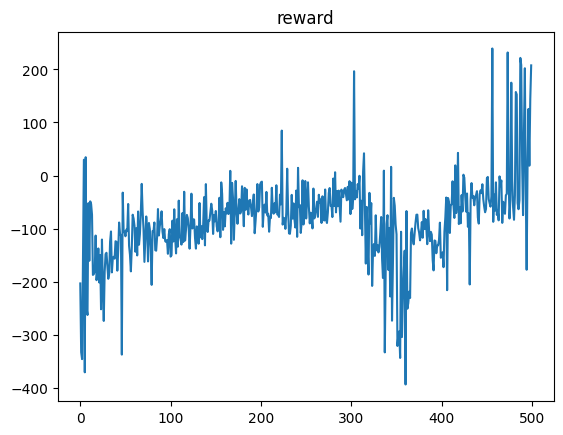

In [10]:
# 使用Matplotlib绘制奖励值的曲线图
plt.plot(episode_rewards)
plt.title("reward")
plt.show()

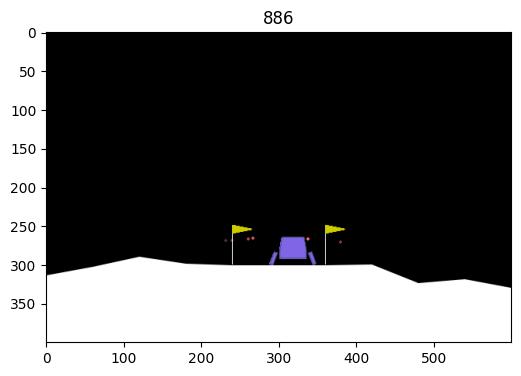

In [ ]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (6, 6))
episode_rewards = []

# 开始游戏
for i in range(1000):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 找到当前状态下的最优动作
    action = agent.choose_action(observation)
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
    episode_rewards.append(reward)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()